## how often to genes in clusters share funciton?

inspired by https://www.nature.com/articles/s41467-021-25129-x, "The molecular basis, genetic control and pleiotropic effects of local gene co-expression", espeically figure 3 and go term enrishment analysis and https://www.nature.com/articles/s42003-022-03831-w "Shared regulation and functional relevance of local gene co-expression revealed by single cell analysis" go term enrichment analysis

* distance in groups vs not X
* paralog frequency X 
* bidirecitonal promotors X
* shared enhancers X 
* shared go term
* same pathway
* same complex 
* inverted/total ctcf motifs between
* hi-c contacts? (from abc data?)
* cross mappability X

I want to make some plots here, and also add all of these annotations to the cluster file. At a later point, perhaps automate the annotation of the clusters file with this information

In [79]:
import numpy as np
import pandas as pd
import scipy as sp
from tqdm.auto import tqdm  # for notebooks
tqdm.pandas()

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import scipy.stats as stats
from sklearn.linear_model import LinearRegression
import math
import upsetplot as up
import ast
import os
import statsmodels as sm

import sys
sys.path.append('/home/klawren/oak/pcqtls/workflow/scripts')
from residualize import calculate_residual
from annotate_clusters import *
from notebook_helper_functions import *
from annotate_null_clusters import *

# get outputs from a config file
prefix = '/home/klawren/oak/pcqtls'
import yaml
config_path= f'{prefix}/config/proteincoding_main.yaml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

clusters_dir = config['clusters_dir']
expression_dir = config['expression_dir']

# load in the tissue ids 
tissue_ids = load_tissue_ids(config)
my_tissue_id = 'Thyroid'

protien_coding_only = True

## load in data
cluster df, expression df, gencode

In [80]:
cluster_df = pd.read_csv(f'{prefix}/{clusters_dir}/{my_tissue_id}_clusters_annotated.csv', index_col=0)
null_pairs_exclude_clusters = pd.read_csv(f'{prefix}/{clusters_dir}/{my_tissue_id}_null_2genes_annotated.csv', index_col=0)
cluster_df.head()

,N_genes,Transcripts,Perc_cor,Mean_cor,Mean_pos_cor,Mean_neg_cor,Chromosome,Tissue,cluster_size,cluster_tss_size,...,has_high_jaccard_weighted,mean_jaccard_unweighted,mean_jaccard_weighted,interval,num_ctcf_peak,has_ctcf_peak,num_ctcf_point,has_ctcf_point,has_neg_corr,has_high_pos_corr
0,12,"ENSG00000143520.6,ENSG00000143536.7,ENSG000001...",0.712121,0.345263,0.412697,-0.081818,1,Thyroid,757449,746178,...,False,0.066279,0.006948,"(36140330.0, 36267530.0]",5.0,True,5.0,True,True,False
2,4,"ENSG00000117586.10,ENSG00000117592.8,ENSG00000...",0.833333,0.291948,0.291948,NaN,1,Thyroid,486128,462549,...,False,0.000000,0.000000,"(24952730.0, 25231869.0]",9.0,True,9.0,True,False,False
3,4,"ENSG00000069275.12,ENSG00000117280.12,ENSG0000...",0.833333,-0.060394,0.297935,-0.239558,1,Thyroid,137313,99856,...,True,0.544155,0.148282,"(50445091.0, 50490648.0]",2.0,True,2.0,True,True,False
1,4,"ENSG00000058799.14,ENSG00000211452.10,ENSG0000...",0.833333,0.346036,0.346036,NaN,1,Thyroid,116449,56243,...,False,0.000000,0.000000,"(23894004.0, 23972532.0]",4.0,True,4.0,True,False,False
11,3,"ENSG00000137944.17,ENSG00000213516.9,ENSG00000...",1.000000,0.266662,0.266662,NaN,1,Thyroid,87121,34539,...,False,0.000000,0.000000,"(24417879.0, 24528390.0]",4.0,True,4.0,True,False,False


In [81]:
# load in annotated clusters for each tissue
annotated_clusters = {}
annotated_nulls = {}
annotated_multigene_nulls = {}

for tissue_id in tissue_ids:
    annotated_clusters[tissue_id] = pd.read_csv(f'{prefix}/{clusters_dir}/{tissue_id}_clusters_annotated.csv', index_col=0)
    annotated_nulls[tissue_id] = pd.read_csv(f'{prefix}/{clusters_dir}/{tissue_id}_null_2genes_annotated.csv', index_col=0)
    null_3_exclude_clusters = pd.read_csv(f'{prefix}/{clusters_dir}/{my_tissue_id}_null_3genes_annotated.csv', index_col=0)
    null_4_exclude_clusters = pd.read_csv(f'{prefix}/{clusters_dir}/{my_tissue_id}_null_4genes_annotated.csv', index_col=0)
    annotated_multigene_nulls[tissue_id] = pd.concat([annotated_nulls[tissue_id], null_3_exclude_clusters, null_4_exclude_clusters])


In [82]:
combined_clusters = pd.concat([annotated_clusters[t] for t in tissue_ids],  keys=tissue_ids, names=['tissue', '.']).reset_index()
combined_nulls = pd.concat([annotated_nulls[t] for t in tissue_ids], keys=tissue_ids, names=['tissue', '.']).reset_index()
combined_multigene_nulls = pd.concat([annotated_multigene_nulls[t] for t in tissue_ids], keys=tissue_ids, names=['tissue', '.']).reset_index()

In [83]:
sum(combined_clusters['N_genes'] > 7)

51

## annotation functions for clusters

are now in annotate_clusters.py

#### plot overlap between categories in the clusters

In [84]:
def generate_bool_indexed(cluster_df, column_list):
    upset_cluster_df = cluster_df.set_index(column_list[0])
    for column_name in column_list[1:]:
        upset_cluster_df.set_index(column_name, append=True, inplace=True)
    return upset_cluster_df

In [85]:
def get_deviation(cluster_df, column_list, type='count'):
    bool_indexed_clusters = generate_bool_indexed(cluster_df,column_list)
    f_observed = up.query(bool_indexed_clusters).subset_sizes

    category_totals = up.query(bool_indexed_clusters).category_totals
    inverse_category_totals = len(cluster_df) - category_totals

    f_expected = f_observed.copy()

    for idx, row in pd.DataFrame(f_expected).iterrows():
        # select the marginal totals corresponding to this index
        values_from_true_index = category_totals[list(idx)].values
        values_from_false_index = inverse_category_totals[[not i for i in idx]].values
        marginal_values = np.concatenate([values_from_false_index, values_from_true_index])
        marginal_percents = marginal_values/len(cluster_df)
        # set the value
        f_expected.loc[idx] = np.prod(marginal_percents) * len(cluster_df)

    # could do this as percent, but that emphasizs small cats
    if type=='percent':
        return (f_observed - f_expected) / f_expected * 100 
    elif type=='count':
        return (f_observed - f_expected)

In [86]:
def plot_upset_binary_categories(cluster_df, column_list, min_subset_size=5, plot_deviation=True):
    bool_indexed_clusters = generate_bool_indexed(cluster_df, column_list)
    deviation = get_deviation(cluster_df, column_list)

    bool_indexed_with_deviation = bool_indexed_clusters.join(deviation.rename('deviation'))
    
    fig = plt.figure(figsize=(8, 5))
    upset = up.UpSet(bool_indexed_with_deviation, show_counts=True, min_subset_size=min_subset_size, sort_by='cardinality')
    if plot_deviation:
        upset.add_catplot(kind='bar', value='deviation', width=.6, color='k')
    upset.plot(fig=fig)


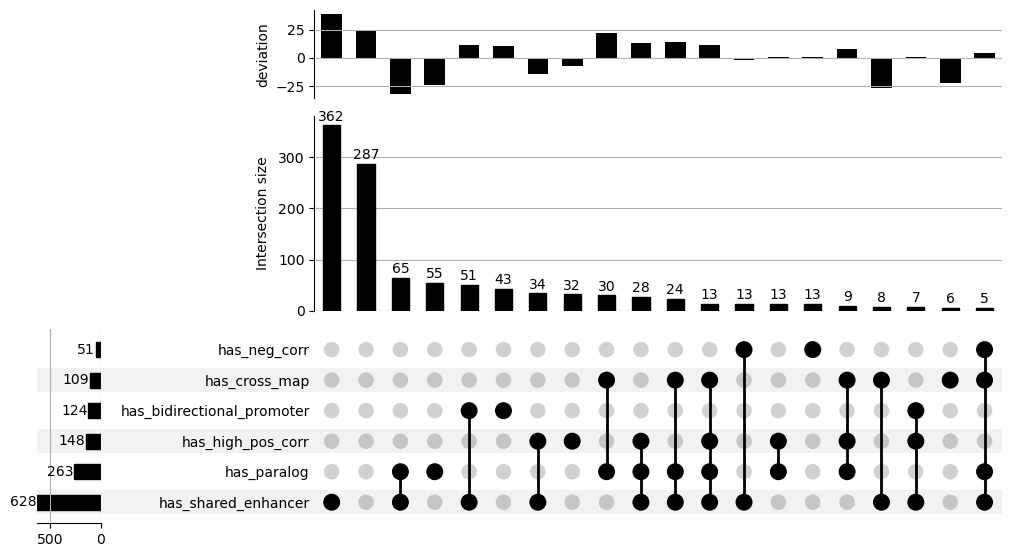

In [87]:
plot_upset_binary_categories(cluster_df, ['has_bidirectional_promoter', 'has_shared_enhancer', 'has_paralog', 'has_cross_map', 'has_neg_corr', 'has_high_pos_corr'])

## plotting functions

#### look at distributions of varis in cluster vs null df 

In [88]:
joined_df = pd.concat([cluster_df[cluster_df['N_genes']==2], null_pairs_exclude_clusters], keys=['cluster', 'null'], names=['type', 'idx'])

<AxesSubplot: xlabel='num_shared_go_any', ylabel='Density'>

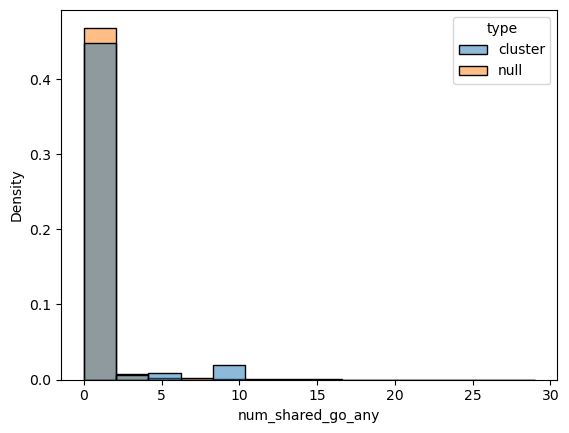

In [89]:
sns.histplot(data=joined_df, hue='type', x='num_shared_go_any', stat='density', common_norm=False)

<AxesSubplot: xlabel='num_ctcf_peak', ylabel='Density'>

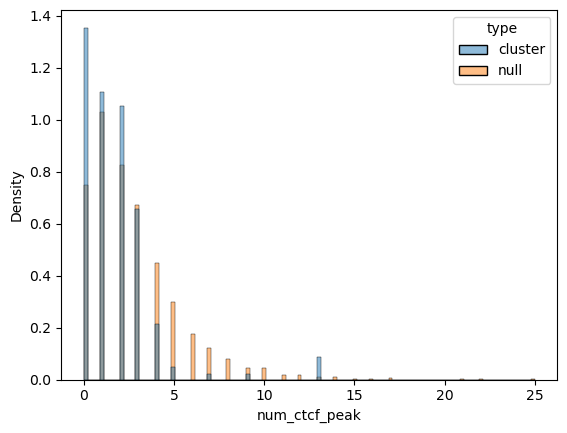

In [90]:
sns.histplot(data=joined_df, hue='type', x='num_ctcf_peak', stat='density', common_norm=False)

<AxesSubplot: xlabel='max_jaccard_unweighted', ylabel='Density'>

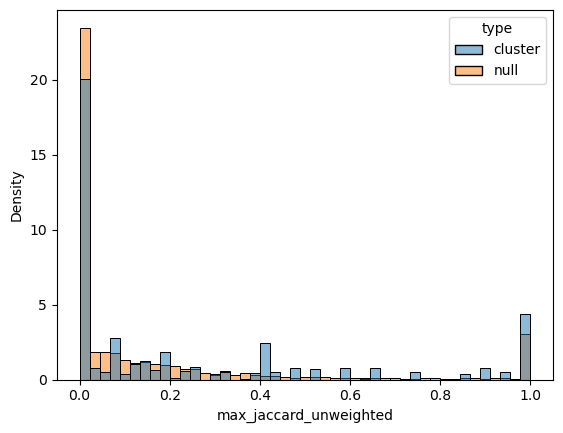

In [91]:
sns.histplot(data=joined_df[~joined_df['max_jaccard_unweighted'].isna()], hue='type', x='max_jaccard_unweighted', stat='density', common_norm=False)

<AxesSubplot: xlabel='max_jaccard_unweighted', ylabel='Density'>

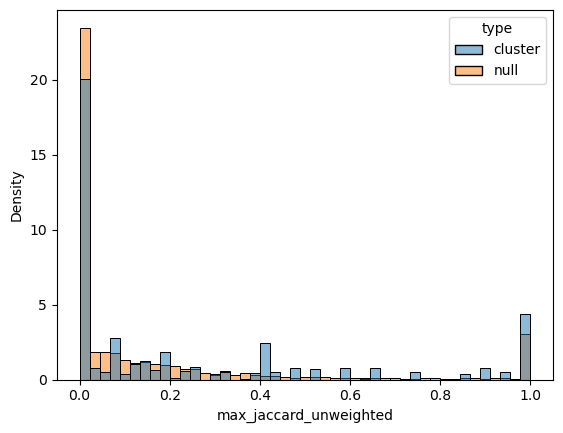

In [92]:
sns.histplot(data=joined_df[~joined_df['max_jaccard_unweighted'].isna()], hue='type', x='max_jaccard_unweighted', stat='density', common_norm=False)

<AxesSubplot: xlabel='max_jaccard_weighted', ylabel='Density'>

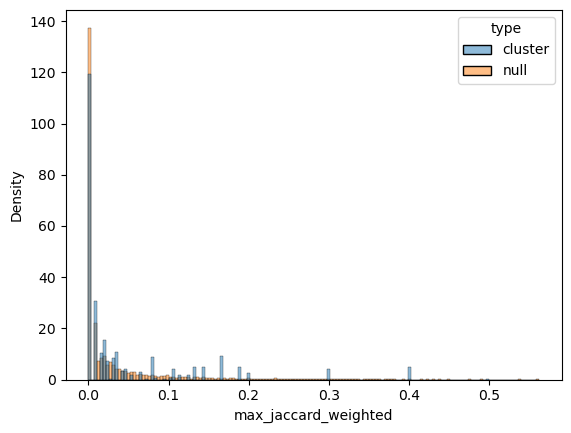

In [93]:
sns.histplot(data=joined_df[~joined_df['max_jaccard_weighted'].isna()], hue='type', x='max_jaccard_weighted', stat='density', common_norm=False)

<AxesSubplot: xlabel='num_strong_enhancers', ylabel='Density'>

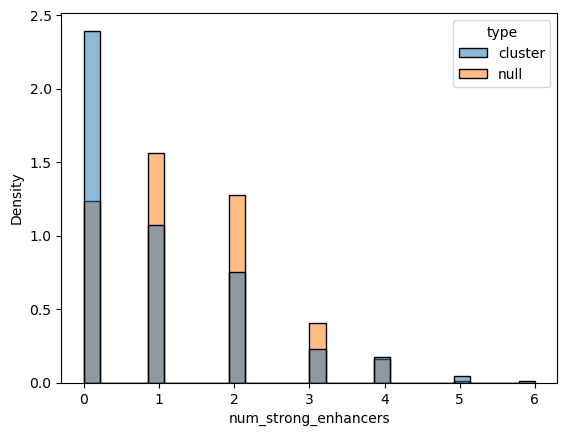

In [94]:
sns.histplot(data=joined_df, hue='type', x='num_strong_enhancers', stat='density', common_norm=False)

<AxesSubplot: xlabel='num_enhancers', ylabel='Density'>

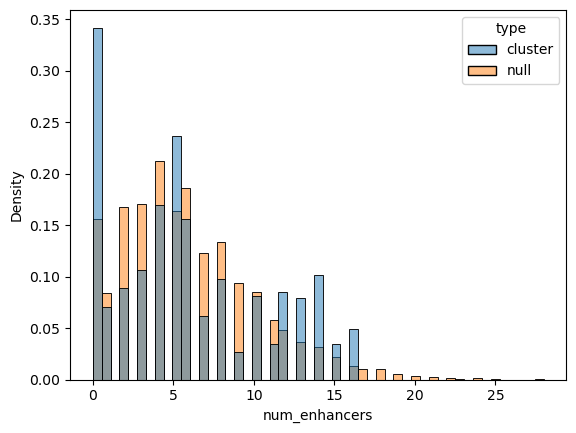

In [95]:
sns.histplot(data=joined_df, hue='type', x='num_enhancers', stat='density', common_norm=False)

<AxesSubplot: xlabel='num_shared_enhancers', ylabel='Density'>

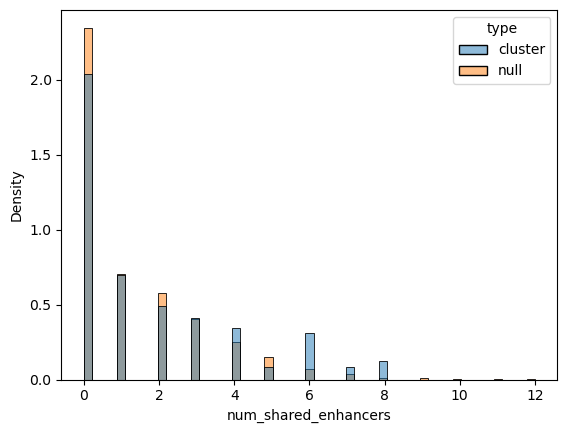

In [96]:
sns.histplot(data=joined_df, hue='type', x='num_shared_enhancers', stat='density', common_norm=False)

<AxesSubplot: xlabel='cluster_size', ylabel='Density'>

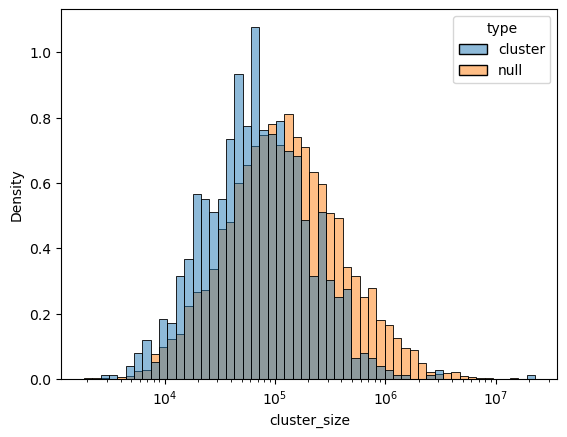

In [97]:
sns.histplot(data=joined_df, hue='type', x='cluster_size', stat='density', log_scale=True, common_norm=False)

<AxesSubplot: xlabel='cluster_tss_size', ylabel='Density'>

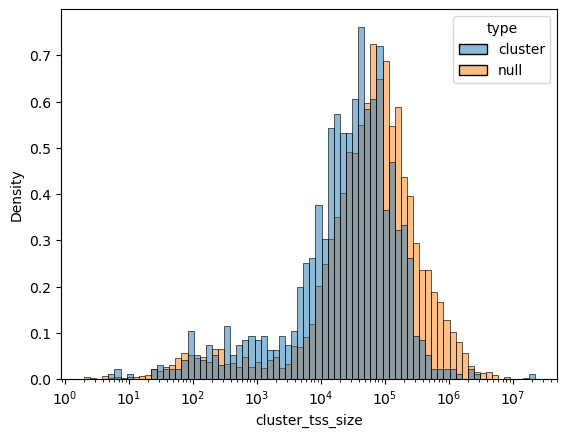

In [98]:
sns.histplot(data=joined_df, hue='type', x='cluster_tss_size', stat='density', log_scale=True, common_norm=False)

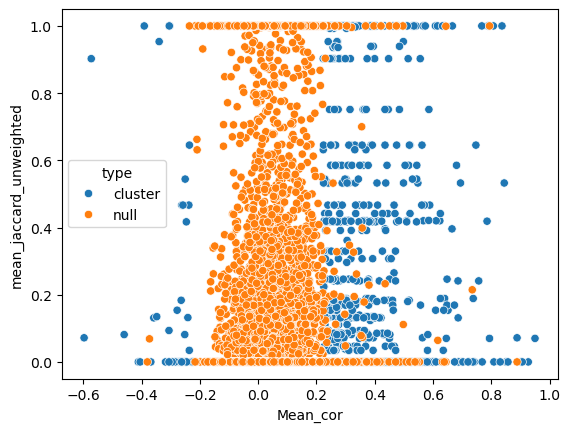

PearsonRResult(statistic=0.12512565461975242, pvalue=2.157150419614188e-22)

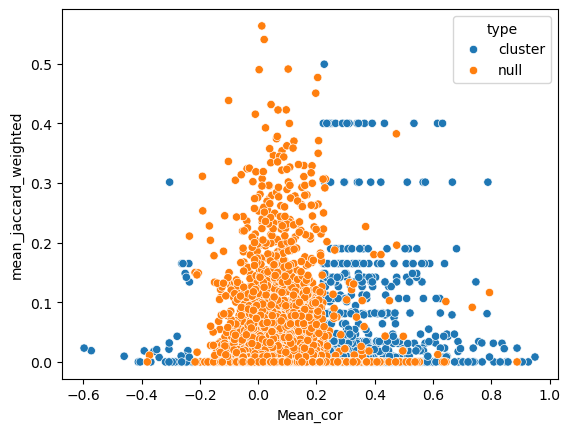

In [99]:
sns.scatterplot(joined_df[~joined_df['mean_jaccard_unweighted'].isna()], x='Mean_cor', y='mean_jaccard_unweighted', hue='type')
plt.show()
sns.scatterplot(joined_df[~joined_df['mean_jaccard_weighted'].isna()], x='Mean_cor', y='mean_jaccard_weighted', hue='type')

stats.pearsonr(joined_df[~joined_df['mean_jaccard_unweighted'].isna()]['mean_jaccard_unweighted'], joined_df[~joined_df['mean_jaccard_unweighted'].isna()]['Mean_cor'])

### log odds

In [100]:
# plot odds ratios

def get_odds_ratio(contingency_table, verb=0):
    # One-sided Fisher's exact test
    odds_ratio, p_value = stats.fisher_exact(contingency_table)
    if verb > 0:
        print("Odds Ratio:", odds_ratio)
        print("P-value:", p_value)

    # Compute 95% confidence interval for odds ratio
    a, b, c, d = contingency_table.flatten()
    SE = np.sqrt(1/a + 1/b + 1/c + 1/d)
    if odds_ratio==0:
        lcb=0
        ucb=0
    else:
        lcb = math.exp(math.log(odds_ratio) - 1.96*SE)  # lower confidence bound
        ucb = math.exp(math.log(odds_ratio) + 1.96*SE)  # upper confidence bound
    if verb > 0:
        print(f"CI: [{lcb}, {ucb}]")

    return p_value, odds_ratio, lcb, ucb

def get_contingency_table(cluster_df, null_df, column_name):
    num_cluster = sum(cluster_df[column_name])
    num_null = sum(null_df[column_name])
    # Build contingency table
    # [[yes clusters, no clusters] [yes null, no null]]
    contingency_table = np.array([[num_cluster, len(cluster_df)-num_cluster],[num_null, len(null_df)-num_null]])
    return contingency_table

def get_log_odds(cluster_df, null_df, column_list):
    log_odds_df = []
    for column_name in column_list:
        p_value, odds_ratio, lcb, ucb = get_odds_ratio(get_contingency_table(cluster_df, null_df, column_name))
        log_odds_df.append(pd.Series({'p_value': p_value,
                'odds_ratio':odds_ratio,
                'lower_cb':lcb,
                'upper_cb':ucb,
                'lower_cb_diff': odds_ratio - lcb,
                'upper_cb_diff': ucb - odds_ratio,
                'col':column_name}))
    return pd.DataFrame(log_odds_df)


# percent belonging to category
def get_frac(column_name, df):
    return sum(df[column_name])/len(df)

In [101]:
def plot_log_odds(cluster_df, null_df, column_list):
    log_odds_df = get_log_odds(cluster_df,null_df, column_list)
    log_odds_df['frac_cluster'] = log_odds_df['col'].apply(get_frac, args=(cluster_df,))
    log_odds_df['frac_null'] = log_odds_df['col'].apply(get_frac, args=(null_df,))
    make_log_odds_frac_plot(log_odds_df)

def make_log_odds_frac_plot(log_odds_df):
    fig, axes = plt.subplots(1, 2, figsize=(12,9))
    make_log_odds_plot(log_odds_df, ax=axes[0])
    make_fraction_plot(log_odds_df, ax=axes[1])
    axes[0].set_ylim(axes[1].get_ylim())
    return axes


def make_log_odds_plot(log_odds_df, ax=None):
    log_odds_df = log_odds_df.reset_index()
    if ax==None:
        fig, ax = plt.subplots(1, figsize=(9,9))

    # log odds plot
    ax.errorbar(y=log_odds_df['col'], x=log_odds_df['odds_ratio'], xerr=log_odds_df[['lower_cb_diff', 'upper_cb_diff']].values.transpose(), fmt="o")
    ax.axvline(1, color='k', linestyle='--')
    ax.set_xlabel('Log odds')

    for idx,row in log_odds_df.iterrows():
        ax.annotate('OR = {:.2f}, p={:.1E}'.format(row['odds_ratio'], row['p_value']), (row['odds_ratio'], idx+.15))
        #axes[0].annotate('log odds={:.1f}'.format(np.log(row['odds_ratio'])), (row['odds_ratio'], idx-.3))
    ax.set_xscale(u'log')
    return ax


def make_fraction_plot(log_odds_df, ax=None):
    if ax==None:
        fig, ax = plt.subplots(1, figsize=(9,9))
    # fraction plot
    sns.barplot(data=log_odds_df, x='frac_cluster', y='col', ax=ax)
    ax.set_yticklabels([])
    ax.set_ylabel('')
    ax.set_xlabel('Fraction in category')

    # make the labels match in order and position
    ax.invert_yaxis()
    return ax

/local/scratch/klawren/slrmtmp.44132591/ipykernel_21560/3080165456.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  SE = np.sqrt(1/a + 1/b + 1/c + 1/d)


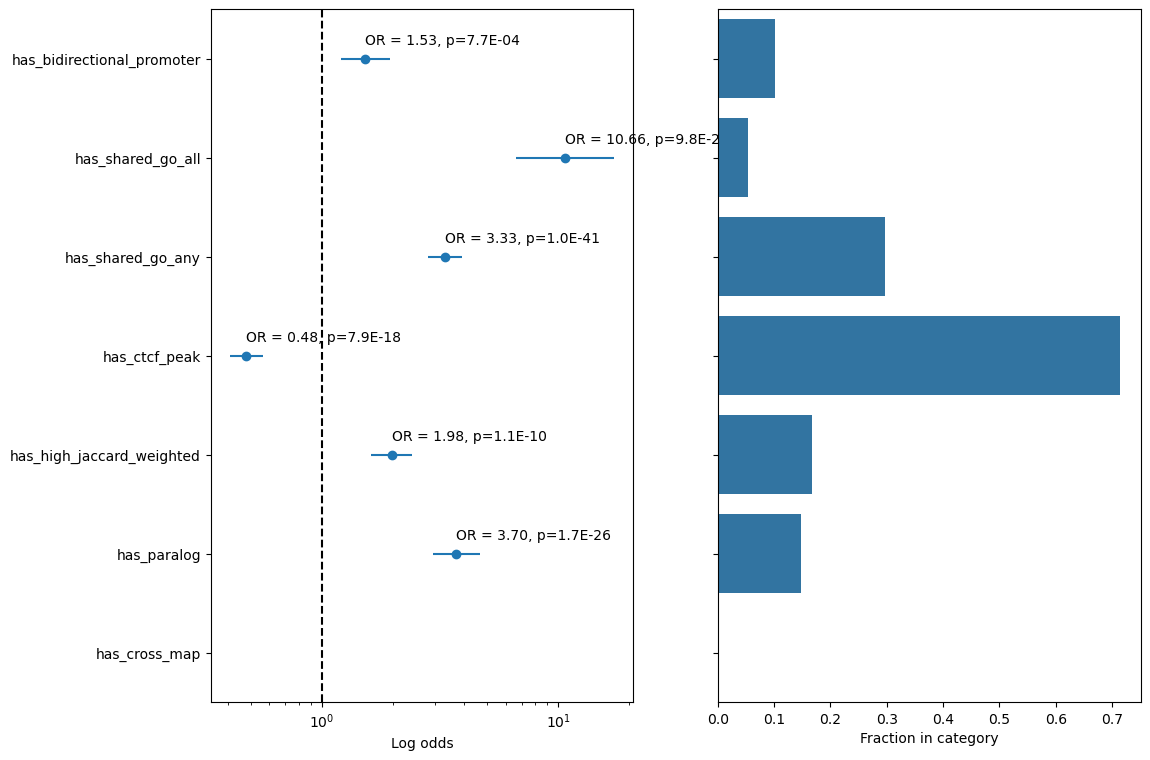

In [102]:
axes = plot_log_odds(cluster_df[(cluster_df['N_genes']==2)&(cluster_df['has_cross_map']==False)], null_pairs_exclude_clusters[null_pairs_exclude_clusters['has_cross_map']==False], ['has_cross_map',
                                                                        'has_paralog', 
                                                                        #'has_high_jaccard_unweighted', 
                                                                        'has_high_jaccard_weighted', 
                                                                        #'has_shared_enhancer', 
                                                                        'has_ctcf_peak',
                                                                        #'has_complexes', 
                                                                        'has_shared_go_any', 
                                                                        'has_shared_go_all', 
                                                                        'has_bidirectional_promoter'])
#axes[0].set_title('Excluding cross mappable genes')

#### plot for continuous vars

using the number of things for the continuous variables
* num_ctcf_peak
* mean_jaccard_weighted
* log cluster_tss_size
* num_shared_go_any


binary vars (for pairs)
* num_cross_map
* num_paralog
* num_bidirectional_promoter
* num_shared_go_all

this approach also allows us to include N_genes as a covariate

In [103]:
import statsmodels.api as sm

In [104]:
# add log size (for size corrections)
cluster_df['log_size'] = np.log10(cluster_df['cluster_tss_size'])
null_pairs_exclude_clusters['log_size'] = np.log10(null_pairs_exclude_clusters['cluster_tss_size'])


# balanced classes? not sure if this matters
#joined_df = pd.concat([cluster_df[cluster_df['N_genes']==2], null_pairs_exclude_clusters.sample(sum(cluster_df['N_genes']==2))], keys=['cluster', 'null'], names=['type', 'idx'])
joined_df = pd.concat([cluster_df[cluster_df['N_genes']==2], null_pairs_exclude_clusters], keys=['cluster', 'null'], names=['type', 'idx'])

joined_no_crossmap_df = joined_df[~joined_df['has_cross_map']]

In [105]:
# fit a logit model

def fit_logistic_model(joined_df, column, correct_on=False, filter_on_column=None, verb=True, correct_on_column='log_size'):
    if verb:
        print(column)
    try:
        final_joined_df = joined_df[joined_df[filter_on_column]!=0]
    except KeyError:
        final_joined_df = joined_df

    if correct_on:
        x = final_joined_df[np.append(np.asarray(correct_on_column),column)].astype(float)
    else:
        x = final_joined_df[column].astype(float)

    y = final_joined_df.reset_index()['type'].values == 'cluster'
    x_with_constant = sm.add_constant(x) # Add intercept term

    logit_model = sm.Logit(y, x_with_constant)
    try:
        result = logit_model.fit()
    except np.linalg.LinAlgError:
        print(joined_df.head())
        print(column)
        sns.histplot(joined_df[column])
        raise np.linalg.LinAlgError
    if verb:
        print(result.summary())

    coefficients = result.params
    conf_int = result.conf_int()
    odds_ratios = np.exp(coefficients)
    odds_ratios_ci = np.exp(conf_int)

    odds_ratios_ci.rename(columns={0:'lower_cb', 1:'upper_cb'}, inplace=True)
    odds_ratios_ci['odds_ratio'] = odds_ratios
    odds_ratios_ci['p_value'] = result.pvalues
    odds_ratios_ci['col'] = column
    odds_ratios_ci['lower_cb_diff'] = odds_ratios_ci['odds_ratio'] - odds_ratios_ci['lower_cb']
    odds_ratios_ci['upper_cb_diff'] = odds_ratios_ci['upper_cb'] - odds_ratios_ci['odds_ratio']
    
    return odds_ratios_ci.loc[column]


def get_odds_df(joined_df, verb=True, correct_on=False, correct_on_column='log_size', column_list = ['num_bidirectional_promoter', 'num_shared_enhancers',
       'num_shared_strong_enhancers', 'num_enhancers', 'num_strong_enhancers',
       'num_paralog', 'num_shared_go_all', 'num_shared_go_any',
       'num_ctcf_peak', 'num_ctcf_point', 'log_size', 'max_jaccard_unweighted', 'max_jaccard_weighted'], 
       filter_list=['max_jaccard_unweighted', 'max_jaccard_weighted']):
       column_list = pd.Series(column_list)
       odds_ratios_no_filter = pd.DataFrame([fit_logistic_model(joined_df, c, verb=verb, correct_on=correct_on, correct_on_column=correct_on_column) for c in column_list[~column_list.isin(filter_list)]]) 
       odds_ratios_filtered = pd.DataFrame([fit_logistic_model(joined_df, c, filter_on_column='num_enhancers', verb=verb, correct_on=correct_on, correct_on_column=correct_on_column) for c in column_list[column_list.isin(filter_list)]]) 
       return pd.concat([odds_ratios_no_filter, odds_ratios_filtered])

In [106]:
# log odds plot with multiple odds per category 
def make_log_odds_plot_multiple(odds_ratios_list, ax=None, labels=None, add_annotations=True, offset = 0.2):
    
    if ax==None:
        fig, ax = plt.subplots(1, figsize=(9,9))

    colors = sns.color_palette()  # add more colors if needed
    
    for idx, odds_ratio_df in enumerate(odds_ratios_list):
        odds_ratio_df = odds_ratio_df.reindex(odds_ratios_list[0].index).reset_index()
        color = colors[idx % len(colors)]  # cycle through colors if more than available
        ax.errorbar(y=odds_ratio_df.reset_index().index.values + idx*offset, x=odds_ratio_df['odds_ratio'], 
                    xerr=odds_ratio_df[['lower_cb_diff', 'upper_cb_diff']].values.transpose(), fmt="o", 
                    color=color, label=labels[idx] if labels else None, markersize=3)
        ax.axvline(1, color='k', linestyle='--')

        if add_annotations:
            for row_idx, row in odds_ratio_df.iterrows():
                ax.annotate('OR = {:.2f}, p={:.1E}'.format(row['odds_ratio'], row['p_value']), 
                            (row['odds_ratio'], row_idx + idx*offset + 0.05), fontsize=6)
            
    if labels:
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(reversed(handles), reversed(labels))

    ax.set_xscale(u'log')
    ax.set_yticks(ticks=odds_ratio_df.index.values + (len(odds_ratios_list)-1)*offset/2, labels=(odds_ratio_df['col']))
    return ax

### basic model, odds for each param

num_bidirectional_promoter
Optimization terminated successfully.
         Current function value: 0.451432
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 6007
Model:                          Logit   Df Residuals:                     6005
Method:                           MLE   Df Model:                            1
Date:                Mon, 19 Aug 2024   Pseudo R-squ.:                0.001523
Time:                        11:08:37   Log-Likelihood:                -2711.8
converged:                       True   LL-Null:                       -2715.9
Covariance Type:            nonrobust   LLR p-value:                  0.004025
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -1.6316      0.036 

<AxesSubplot: xlabel='Log odds'>

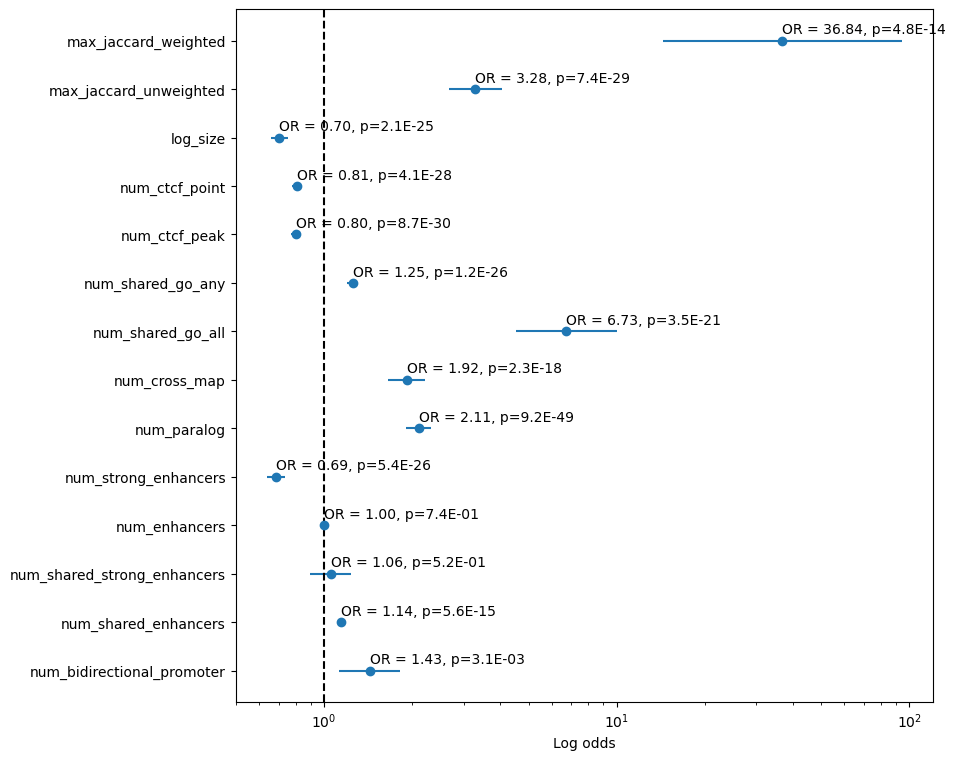

In [107]:
odds_ratios = get_odds_df(joined_df, column_list = ['num_bidirectional_promoter', 'num_shared_enhancers',
       'num_shared_strong_enhancers', 'num_enhancers', 'num_strong_enhancers',
       'num_paralog','num_cross_map', 'num_shared_go_all', 'num_shared_go_any',
       'num_ctcf_peak', 'num_ctcf_point', 'log_size', 'max_jaccard_unweighted', 'max_jaccard_weighted'])
make_log_odds_plot(odds_ratios.reset_index())

num_bidirectional_promoter
Optimization terminated successfully.
         Current function value: 0.437676
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 5810
Model:                          Logit   Df Residuals:                     5808
Method:                           MLE   Df Model:                            1
Date:                Mon, 19 Aug 2024   Pseudo R-squ.:                0.002200
Time:                        11:08:38   Log-Likelihood:                -2542.9
converged:                       True   LL-Null:                       -2548.5
Covariance Type:            nonrobust   LLR p-value:                 0.0008115
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -1.6986      0.038 

<AxesSubplot: >

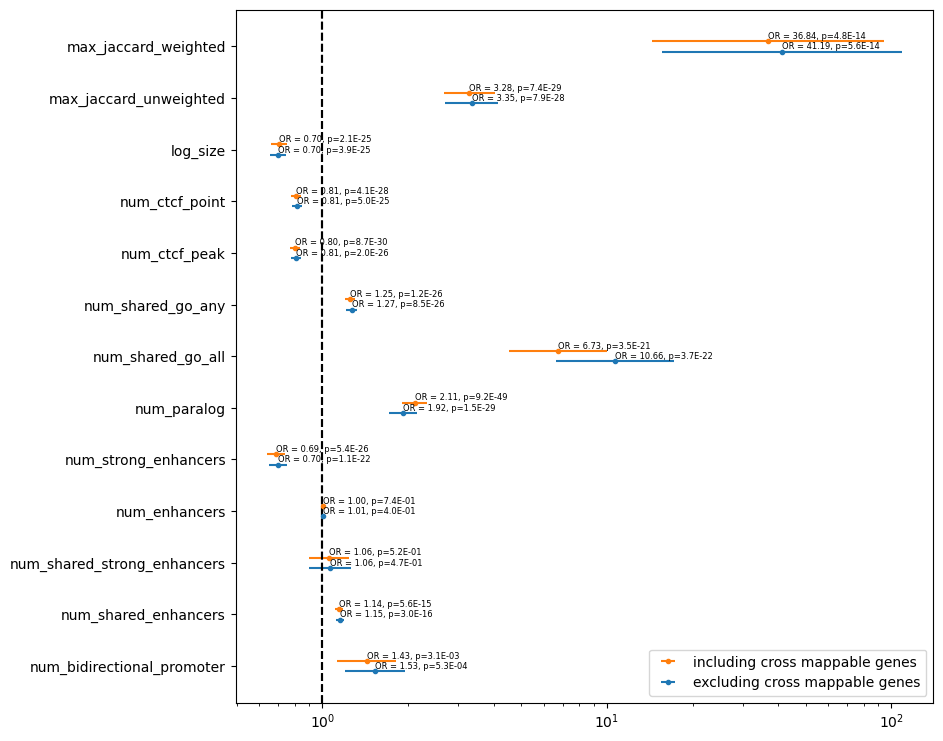

In [108]:
# with and without removing cross mappable (remove for future plots)
odds_ratios_no_cross = get_odds_df(joined_no_crossmap_df)
make_log_odds_plot_multiple([odds_ratios_no_cross, odds_ratios[~(odds_ratios['col'] == 'num_cross_map')]], labels=['excluding cross mappable genes', 'including cross mappable genes'])

### positive vs negative correlation

num_bidirectional_promoter
Optimization terminated successfully.
         Current function value: 0.098927
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 4985
Model:                          Logit   Df Residuals:                     4983
Method:                           MLE   Df Model:                            1
Date:                Mon, 19 Aug 2024   Pseudo R-squ.:                0.001265
Time:                        11:08:40   Log-Likelihood:                -493.15
converged:                       True   LL-Null:                       -493.78
Covariance Type:            nonrobust   LLR p-value:                    0.2637
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -3.9116      0.106 

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 4985
Model:                          Logit   Df Residuals:                     4983
Method:                           MLE   Df Model:                            1
Date:                Mon, 19 Aug 2024   Pseudo R-squ.:                 0.03338
Time:                        11:08:40   Log-Likelihood:                -477.29
converged:                       True   LL-Null:                       -493.78
Covariance Type:            nonrobust   LLR p-value:                 9.385e-09
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -4.3412      0.141    -30.812      0.000      -4.617      -4.065
num_shared_enhancers     0.2591      0.041      6.265      0.000       0.178       0.340
num_shared_s

<AxesSubplot: >

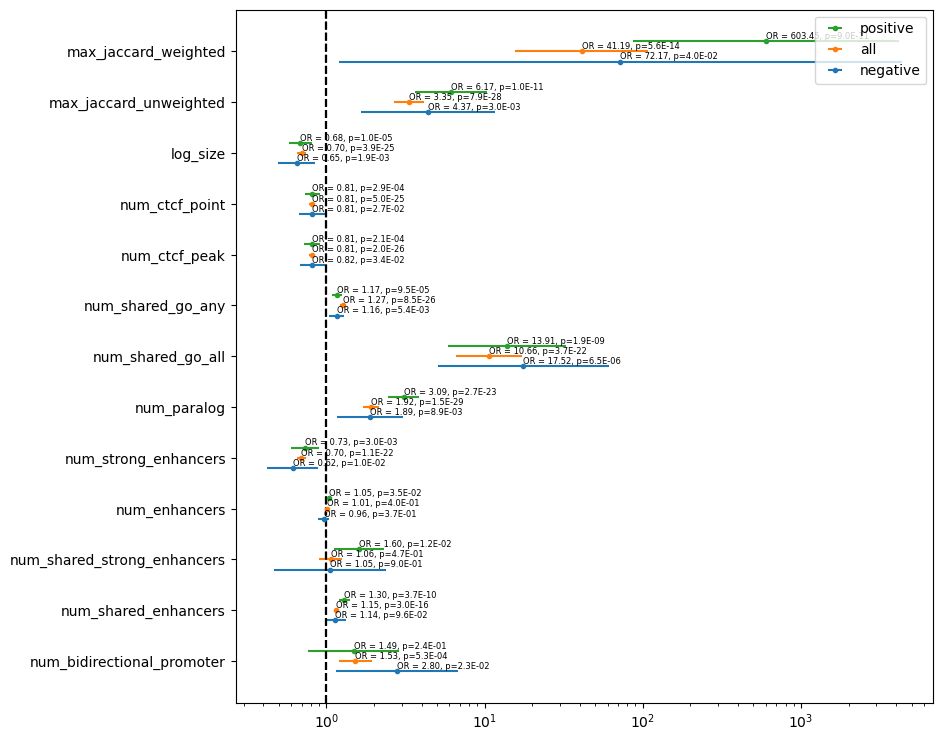

In [109]:
pos_cluster_df = pd.concat([cluster_df[(cluster_df['N_genes']==2) & (cluster_df['has_high_pos_corr'])], null_pairs_exclude_clusters], keys=['cluster', 'null'], names=['type', 'idx'])
pos_cluster_df = pos_cluster_df[~pos_cluster_df['has_cross_map']]
odds_ratios_positive = get_odds_df(pos_cluster_df)

neg_cluster_df = pd.concat([cluster_df[(cluster_df['N_genes']==2) & (cluster_df['has_neg_corr'])], null_pairs_exclude_clusters], keys=['cluster', 'null'], names=['type', 'idx'])
neg_cluster_df = neg_cluster_df[~neg_cluster_df['has_cross_map']]
odds_ratios_negative = get_odds_df(neg_cluster_df)

make_log_odds_plot_multiple([odds_ratios_negative, odds_ratios_no_cross, odds_ratios_positive], labels=['negative', 'all', 'positive'])


#### with and without distance corection

## combining over all tissues

# only combine over tissues with a gtex match
GTEX_tissue,ABC_biosample_id
Adipose_Subcutaneous,adipose_tissue-ENCODE
Adipose_Visceral_Omentum,None
Artery_Tibial,coronary_artery-ENCODE
Cells_Cultured_fibroblasts,fibroblast_of_arm-ENCODE
Esophagus_Mucosa,None
Esophagus_Muscularis,None
Lung,fibroblast_of_lung-Roadmap
Muscle_Skeletal,gastrocnemius_medialis-ENCODE
Nerve_Tibial,None
Skin_Not_Sun_Exposed_Suprapubic,foreskin_fibroblast-Roadmap
Skin_Sun_Exposed_Lower_leg,fibroblast_of_dermis-Roadmap
Thyroid,thyroid_gland-ENCODE
Whole_Blood,Bcells

Adipose_Subcutaneous, Artery_Tibial, Cells_Cultured_fibroblasts, Lung, Muscle_Skeletal, Skin_Not_Sun_Exposed_Suprapubic, Skin_Sun_Exposed_Lower_leg, Thyroid, Whole_Blood

In [110]:
enhancer_tissue_ids = ['Adipose_Subcutaneous', 'Artery_Tibial', 'Cells_Cultured_fibroblasts', 'Lung', 'Muscle_Skeletal', 'Skin_Not_Sun_Exposed_Suprapubic', 'Skin_Sun_Exposed_Lower_leg', 'Thyroid']

tissue_combined_joined_df = pd.concat([combined_clusters[(combined_clusters['N_genes']==2)], combined_nulls], keys=['cluster', 'null'], names=['type', 'idx'])
tissue_combined_joined_df['log_size'] = np.log10(tissue_combined_joined_df['cluster_tss_size'])
tissue_combined_joined_df = tissue_combined_joined_df[~(tissue_combined_joined_df['has_cross_map'])]
tissue_combined_enhancer_joined_df = tissue_combined_joined_df[tissue_combined_joined_df['tissue'].isin(enhancer_tissue_ids)]

num_bidirectional_promoter
Optimization terminated successfully.
         Current function value: 0.411522
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 5708
Model:                          Logit   Df Residuals:                     5706
Method:                           MLE   Df Model:                            1
Date:                Mon, 19 Aug 2024   Pseudo R-squ.:                0.002337
Time:                        11:08:43   Log-Likelihood:                -2349.0
converged:                       True   LL-Null:                       -2354.5
Covariance Type:            nonrobust   LLR p-value:                 0.0009086
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -1.8170      0.040 

/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: overflow encountered in exp
  result = func(self.values, **kwargs)
/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/ho

         Current function value: 0.411391
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 5708
Model:                          Logit   Df Residuals:                     5706
Method:                           MLE   Df Model:                            1
Date:                Mon, 19 Aug 2024   Pseudo R-squ.:                0.002655
Time:                        11:08:43   Log-Likelihood:                -2348.2
converged:                      False   LL-Null:                       -2354.5
Covariance Type:            nonrobust   LLR p-value:                 0.0004062
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -1.7727      0.038    -47.020      0.000      -1.847      -1.699
num_ctcf_peak   -20.0376   1.16e+04     -0.002      0.99

(0.001, 1000)

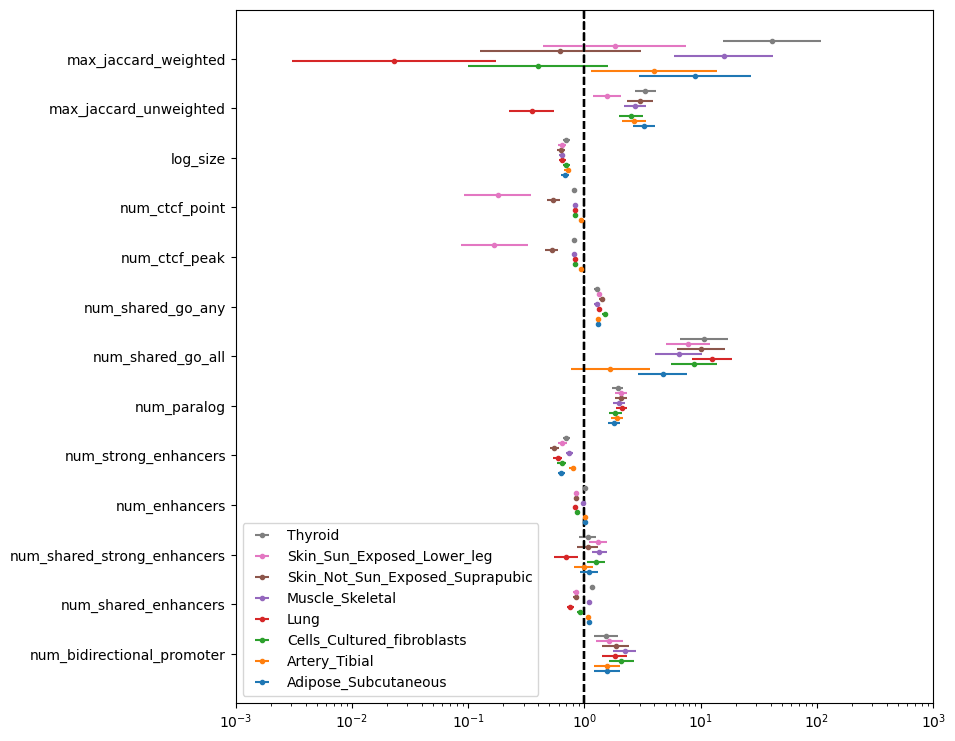

In [111]:
# individual per tissue
odds_ratios = [get_odds_df(tissue_combined_enhancer_joined_df[tissue_combined_enhancer_joined_df['tissue']==t]) for t in enhancer_tissue_ids]
ax = make_log_odds_plot_multiple(odds_ratios, labels=enhancer_tissue_ids, add_annotations=False, offset=.1)
ax.set_xlim(.001, 1000)

num_bidirectional_promoter
Optimization terminated successfully.
         Current function value: 0.403692
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                45423
Model:                          Logit   Df Residuals:                    45421
Method:                           MLE   Df Model:                            1
Date:                Mon, 19 Aug 2024   Pseudo R-squ.:                0.004199
Time:                        11:08:51   Log-Likelihood:                -18337.
converged:                       True   LL-Null:                       -18414.
Covariance Type:            nonrobust   LLR p-value:                 1.666e-35
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -1.8647      0.014 

<AxesSubplot: >

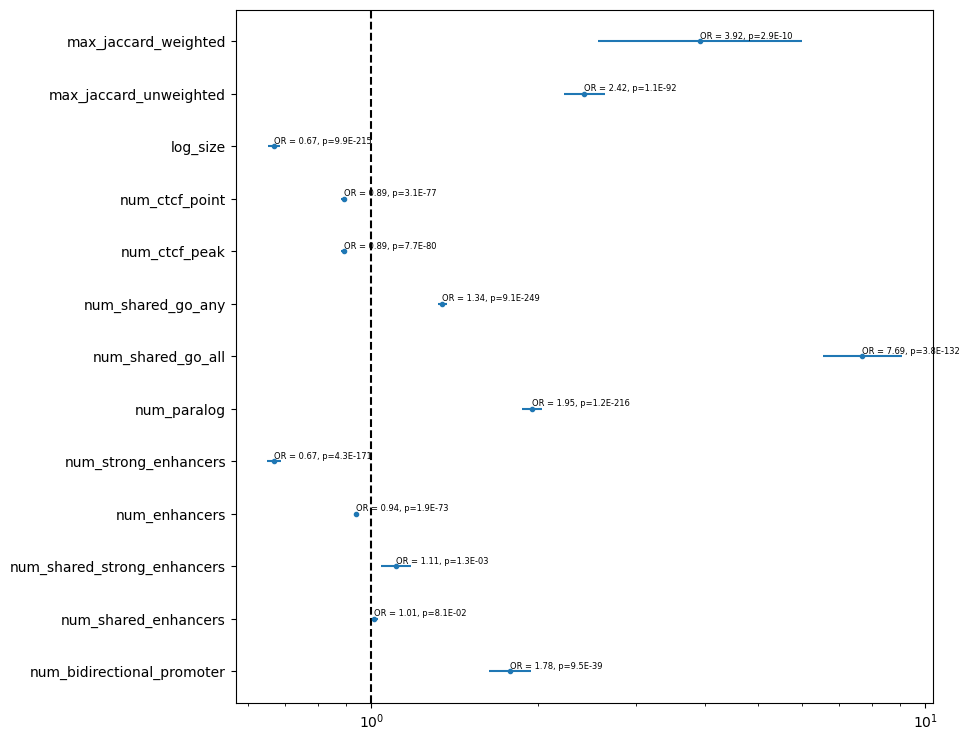

In [112]:
# these look reasonably similar, combine over them
odds_ratios_enhancer = get_odds_df(tissue_combined_enhancer_joined_df)
make_log_odds_plot_multiple([odds_ratios_enhancer])

num_bidirectional_promoter
Optimization terminated successfully.
         Current function value: 0.079946
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                39670
Model:                          Logit   Df Residuals:                    39668
Method:                           MLE   Df Model:                            1
Date:                Mon, 19 Aug 2024   Pseudo R-squ.:                0.003010
Time:                        11:08:56   Log-Likelihood:                -3171.5
converged:                       True   LL-Null:                       -3181.0
Covariance Type:            nonrobust   LLR p-value:                 1.210e-05
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -4.2017      0.043 

<AxesSubplot: >

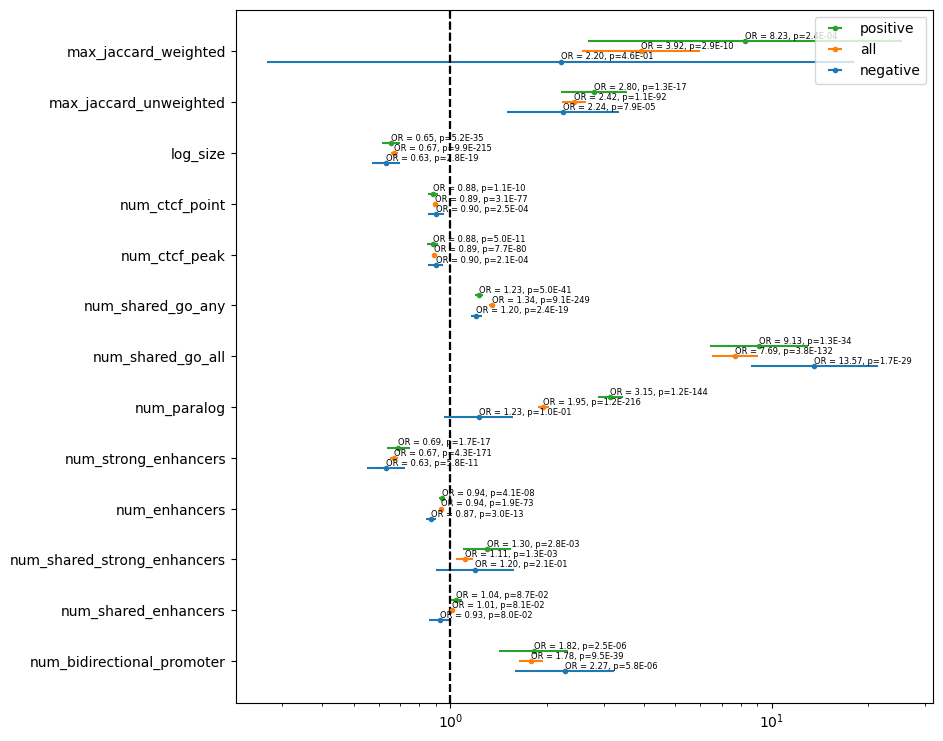

In [113]:
# positive negative plot combining over tissues
tissue_combined_enhancer_joined_df  = tissue_combined_enhancer_joined_df.reset_index()
combined_pos_df = tissue_combined_enhancer_joined_df[((tissue_combined_enhancer_joined_df['type']=='cluster')&(tissue_combined_enhancer_joined_df['has_high_pos_corr'])) | (tissue_combined_enhancer_joined_df['type']=='null')]
combined_neg_df = tissue_combined_enhancer_joined_df[((tissue_combined_enhancer_joined_df['type']=='cluster')&(tissue_combined_enhancer_joined_df['has_neg_corr'])) | (tissue_combined_enhancer_joined_df['type']=='null')]
odds_ratios_positive = get_odds_df(combined_pos_df)
odds_ratios_negative = get_odds_df(combined_neg_df)

make_log_odds_plot_multiple([odds_ratios_negative, odds_ratios_enhancer, odds_ratios_positive], labels=['negative', 'all', 'positive'])


num_bidirectional_promoter
Optimization terminated successfully.
         Current function value: 0.393475
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                73369
Model:                          Logit   Df Residuals:                    73367
Method:                           MLE   Df Model:                            1
Date:                Mon, 19 Aug 2024   Pseudo R-squ.:                0.003801
Time:                        11:09:06   Log-Likelihood:                -28869.
converged:                       True   LL-Null:                       -28979.
Covariance Type:            nonrobust   LLR p-value:                 7.736e-50
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -1.9099      0.011 

<AxesSubplot: >

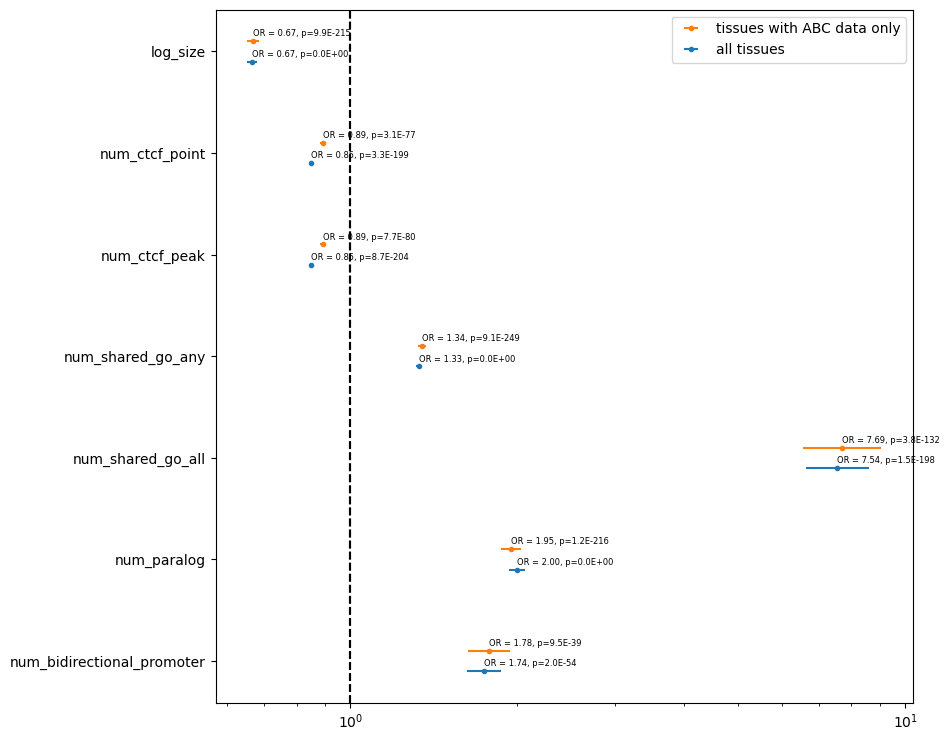

In [114]:
column_list = ['num_bidirectional_promoter',
       'num_paralog', 'num_shared_go_all', 'num_shared_go_any',
       'num_ctcf_peak', 'num_ctcf_point', 'log_size']
odds_ratios_no_enhancer = get_odds_df(tissue_combined_joined_df, column_list=column_list)

make_log_odds_plot_multiple([odds_ratios_no_enhancer, odds_ratios_enhancer], labels=['all tissues', 'tissues with ABC data only'])

num_bidirectional_promoter
Optimization terminated successfully.
         Current function value: 0.685745
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 1234
Model:                          Logit   Df Residuals:                     1232
Method:                           MLE   Df Model:                            1
Date:                Mon, 19 Aug 2024   Pseudo R-squ.:                 0.01068
Time:                        11:09:10   Log-Likelihood:                -846.21
converged:                       True   LL-Null:                       -855.34
Covariance Type:            nonrobust   LLR p-value:                 1.919e-05
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -0.0725      0.060 

/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: overflow encountered in exp
  result = func(self.values, **kwargs)


<AxesSubplot: >

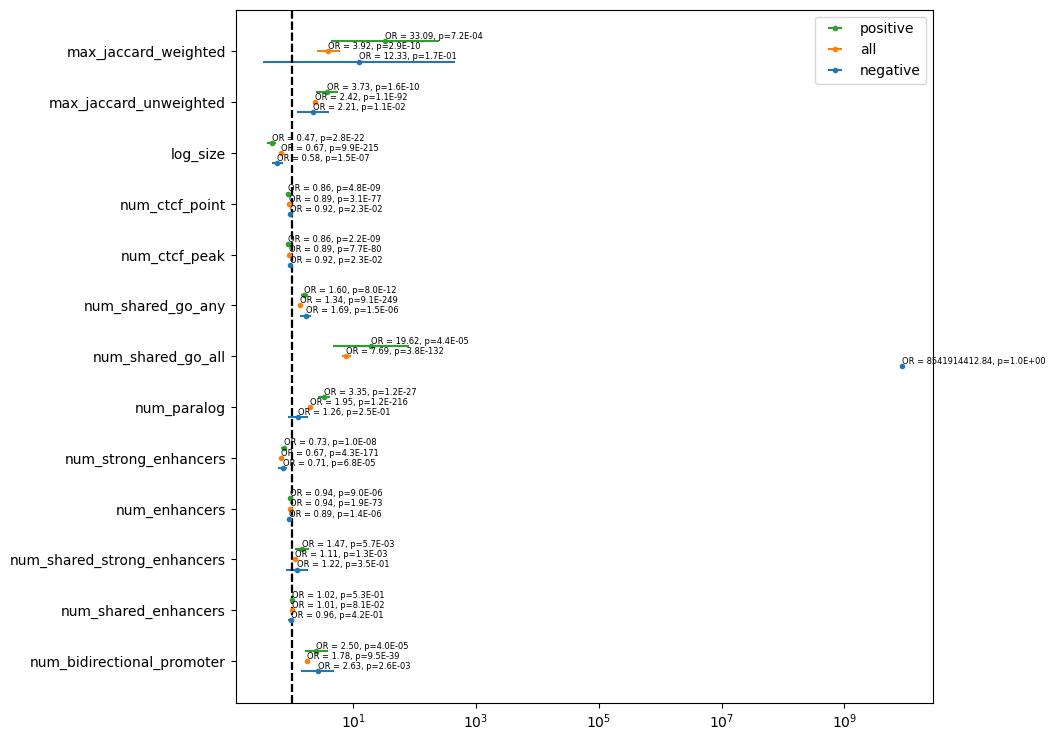

In [115]:
# balanced classes?
combined_pos_df = tissue_combined_enhancer_joined_df[((tissue_combined_enhancer_joined_df['type']=='cluster')&(tissue_combined_enhancer_joined_df['has_high_pos_corr']))]
combined_pos_df = pd.concat([combined_pos_df, tissue_combined_enhancer_joined_df[tissue_combined_enhancer_joined_df['type']=='null'].sample(len(combined_pos_df))])
combined_neg_df = tissue_combined_enhancer_joined_df[((tissue_combined_enhancer_joined_df['type']=='cluster')&(tissue_combined_enhancer_joined_df['has_neg_corr']))]
combined_neg_df = pd.concat([combined_neg_df, tissue_combined_enhancer_joined_df[tissue_combined_enhancer_joined_df['type']=='null'].sample(len(combined_neg_df))])

odds_ratios_positive = get_odds_df(combined_pos_df)
odds_ratios_negative = get_odds_df(combined_neg_df)

make_log_odds_plot_multiple([odds_ratios_negative, odds_ratios_enhancer, odds_ratios_positive], labels=['negative', 'all', 'positive'])


max_jaccard_weighted_100
Optimization terminated successfully.
         Current function value: 0.379472
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                41239
Model:                          Logit   Df Residuals:                    41237
Method:                           MLE   Df Model:                            1
Date:                Mon, 19 Aug 2024   Pseudo R-squ.:                0.001194
Time:                        11:09:11   Log-Likelihood:                -15649.
converged:                       True   LL-Null:                       -15668.
Covariance Type:            nonrobust   LLR p-value:                 9.611e-10
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -1.9805      0.017   -116.6

<AxesSubplot: xlabel='Log odds'>

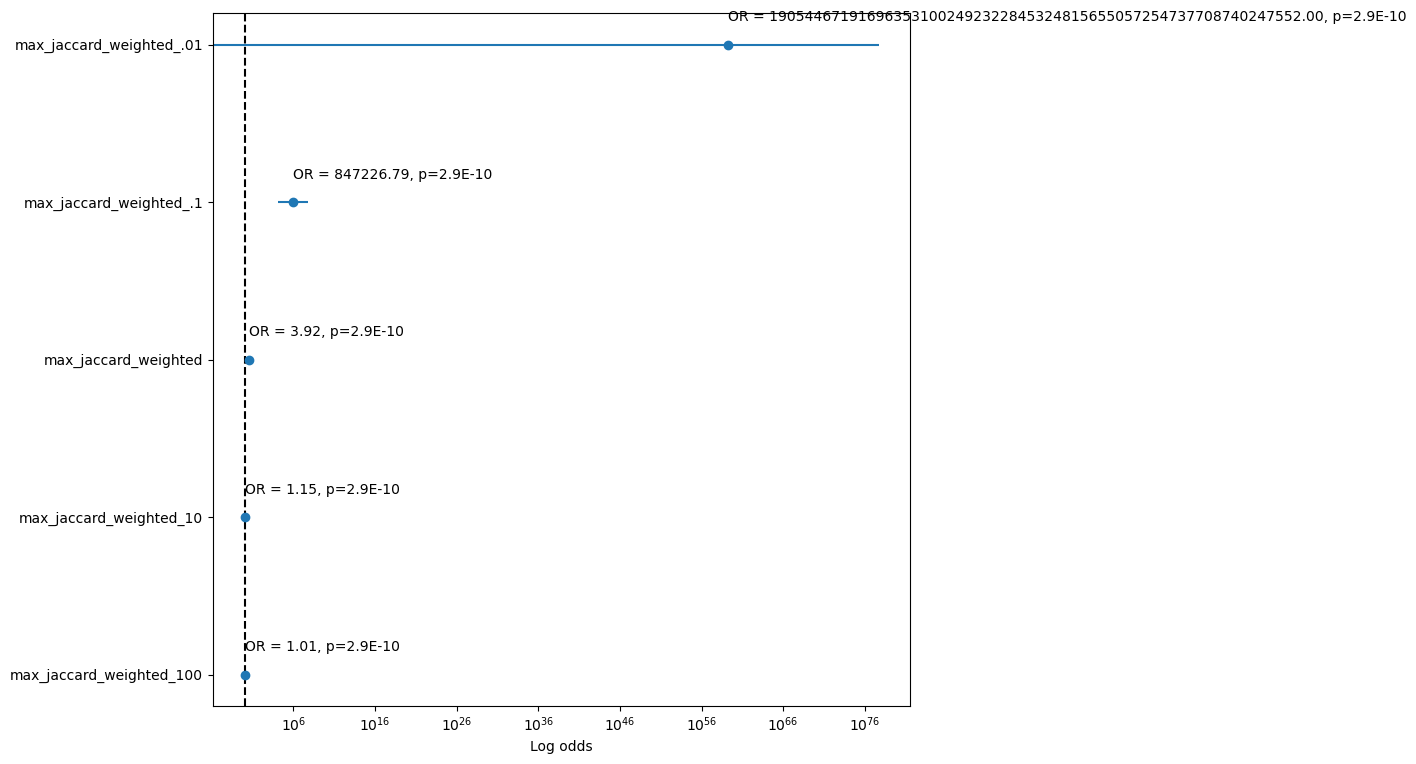

In [116]:
tissue_combined_enhancer_joined_df['max_jaccard_weighted_10'] = tissue_combined_enhancer_joined_df['max_jaccard_weighted'] * 10
tissue_combined_enhancer_joined_df['max_jaccard_weighted_100'] = tissue_combined_enhancer_joined_df['max_jaccard_weighted'] * 100

tissue_combined_enhancer_joined_df['max_jaccard_weighted_.1'] = tissue_combined_enhancer_joined_df['max_jaccard_weighted']/ 10
tissue_combined_enhancer_joined_df['max_jaccard_weighted_.01'] = tissue_combined_enhancer_joined_df['max_jaccard_weighted']/100

odds_ratios_jaccard_scaled = get_odds_df(tissue_combined_enhancer_joined_df, column_list=['max_jaccard_weighted_100','max_jaccard_weighted_10','max_jaccard_weighted', 'max_jaccard_weighted_.1', 'max_jaccard_weighted_.01'], 
filter_list=['max_jaccard_weighted_100','max_jaccard_weighted_10','max_jaccard_weighted', 'max_jaccard_weighted_.1', 'max_jaccard_weighted_.01'])

make_log_odds_plot(odds_ratios_jaccard_scaled)

/home/klawren/oak/pcqtls/workflow/scripts/annotate_null_clusters.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_df['normed_log_size'] = np.log10(cluster_df['cluster_tss_size'])/np.log10(join_df['cluster_tss_size'].max())


num_bidirectional_promoter
Optimization terminated successfully.
         Current function value: 0.407226
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                45094
Model:                          Logit   Df Residuals:                    45092
Method:                           MLE   Df Model:                            1
Date:                Mon, 19 Aug 2024   Pseudo R-squ.:               4.595e-05
Time:                        11:09:34   Log-Likelihood:                -18363.
converged:                       True   LL-Null:                       -18364.
Covariance Type:            nonrobust   LLR p-value:                    0.1939
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -1.8111      0.014 

<AxesSubplot: >

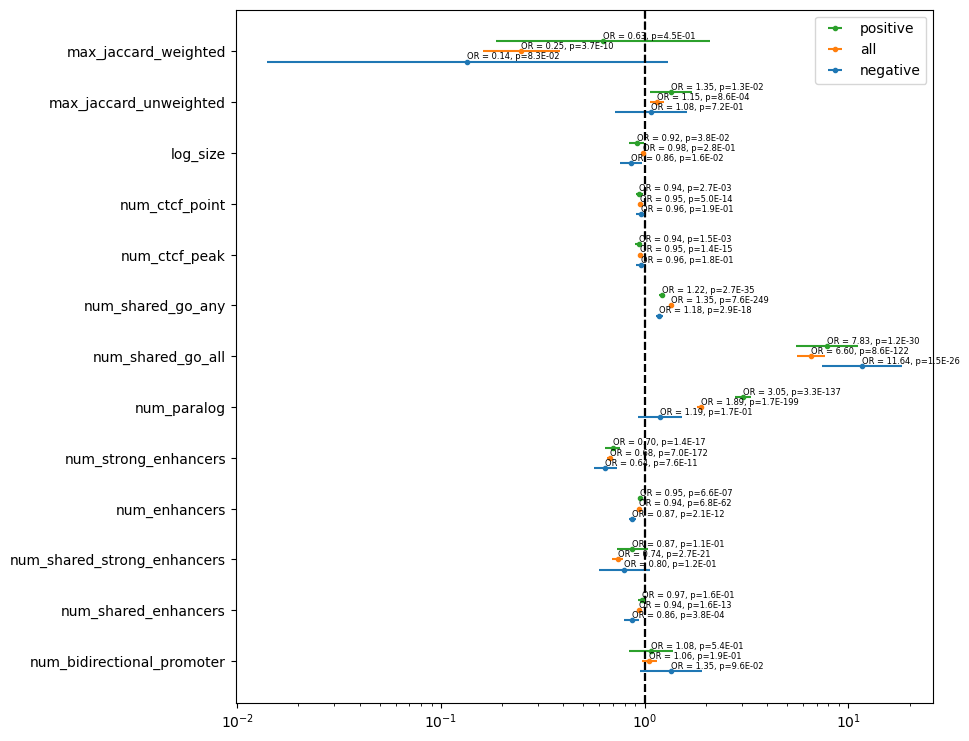

In [117]:
# positive vs negative with distance correction (resampled null?)
tissue_combined_distance_matched_null = get_resamp_null_cluster(combined_nulls, combined_clusters[(combined_clusters['N_genes']==2)], number_null=5000*len(tissue_ids), plot=False)
tissue_combined_resamp_joined_df = pd.concat([combined_clusters[(combined_clusters['N_genes']==2)], tissue_combined_distance_matched_null], keys=['cluster', 'null'], names=['type', 'idx'])
tissue_combined_resamp_joined_df['log_size'] = np.log10(tissue_combined_resamp_joined_df['cluster_tss_size'])
tissue_combined_resamp_joined_df['has_even_ctcf'] = tissue_combined_resamp_joined_df['num_ctcf_point'] %2 == 0
tissue_combined_resamp_joined_df = tissue_combined_resamp_joined_df[~(tissue_combined_resamp_joined_df['has_cross_map'])]
tissue_combined_resamp_joined_df = tissue_combined_resamp_joined_df[tissue_combined_resamp_joined_df['tissue'].isin(enhancer_tissue_ids)]

odds_ratios_tissue_combined_resamp = get_odds_df(tissue_combined_resamp_joined_df)

# positive negative plot combining over tissues
tissue_combined_resamp_joined_df  = tissue_combined_resamp_joined_df.reset_index()
combined_resamp_pos_df = tissue_combined_resamp_joined_df[((tissue_combined_resamp_joined_df['type']=='cluster')&(tissue_combined_resamp_joined_df['has_high_pos_corr'])) | (tissue_combined_resamp_joined_df['type']=='null')]
combined_resamp_neg_df = tissue_combined_resamp_joined_df[((tissue_combined_resamp_joined_df['type']=='cluster')&(tissue_combined_resamp_joined_df['has_neg_corr'])) | (tissue_combined_resamp_joined_df['type']=='null')]
odds_ratios_positive_combined_resamp = get_odds_df(combined_resamp_pos_df)
odds_ratios_negative_combined_resamp = get_odds_df(combined_resamp_neg_df)

make_log_odds_plot_multiple([odds_ratios_negative_combined_resamp, odds_ratios_tissue_combined_resamp, odds_ratios_positive_combined_resamp], labels=['negative', 'all', 'positive'])

### boolean labels

useing boolean columns again so odds ratios acutally mean something
odds_ratios_enhancer

In [118]:
bool_column_list = ['has_paralog', 'has_high_jaccard_unweighted', 'has_high_jaccard_weighted', 'has_shared_enhancer', 'has_shared_strong_enhancer', 'has_ctcf_peak', 
                    'has_shared_go_any', 'has_shared_go_all', 'has_bidirectional_promoter']
bool_filter_list = ['has_high_jaccard_unweighted', 'has_high_jaccard_weighted', 'has_shared_enhancer', 'has_shared_strong_enhancer']

has_paralog
Optimization terminated successfully.
         Current function value: 0.039274
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                38978
Model:                          Logit   Df Residuals:                    38976
Method:                           MLE   Df Model:                            1
Date:                Mon, 19 Aug 2024   Pseudo R-squ.:               0.0005531
Time:                        11:09:49   Log-Likelihood:                -1530.8
converged:                       True   LL-Null:                       -1531.7
Covariance Type:            nonrobust   LLR p-value:                    0.1930
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -5.0466      0.065    -77.442      0.000      -5.174      -4.919
has_paralog   

<AxesSubplot: >

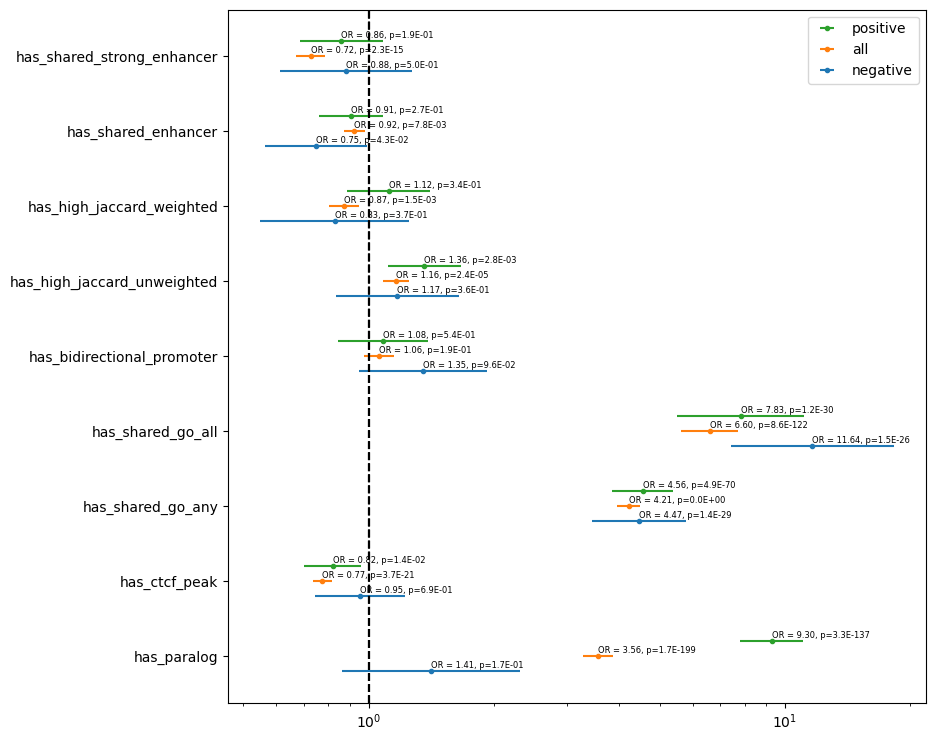

In [119]:
# combined, resamples
make_log_odds_plot_multiple([get_odds_df(combined_resamp_neg_df, column_list=bool_column_list, filter_list=bool_filter_list), 
                             get_odds_df(tissue_combined_resamp_joined_df, column_list=bool_column_list, filter_list=bool_filter_list), 
                             get_odds_df(combined_resamp_pos_df, column_list=bool_column_list, filter_list=bool_filter_list)], 
                             labels=['negative', 'all', 'positive'])

### bigger clusters
* brokedn down by cluster size
* with n_genes as covariate

using resampled distance matched nulls
using all tissue combined

In [120]:
# broken down by cluster size

multigene_resamp_joined_df = {}

for num_genes in [2,3,4]:
    distance_matched_null = get_resamp_null_cluster(combined_multigene_nulls[combined_multigene_nulls['N_genes'] == num_genes], combined_clusters[(combined_clusters['N_genes']==num_genes)], number_null=5000*len(tissue_ids), plot=False)
    resamp_joined_df = pd.concat([combined_clusters[(combined_clusters['N_genes']==num_genes)], distance_matched_null], keys=['cluster', 'null'], names=['type', 'idx'])
    resamp_joined_df['log_size'] = np.log10(resamp_joined_df['cluster_tss_size'])
    resamp_joined_df['has_odd_ctcf'] = resamp_joined_df['num_ctcf_point'] %2 ==0
    resamp_joined_df = resamp_joined_df[~(resamp_joined_df['has_cross_map'])]
    resamp_joined_df = resamp_joined_df[resamp_joined_df['tissue'].isin(enhancer_tissue_ids)]
    multigene_resamp_joined_df[num_genes] = resamp_joined_df


/home/klawren/oak/pcqtls/workflow/scripts/annotate_null_clusters.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_df['normed_log_size'] = np.log10(cluster_df['cluster_tss_size'])/np.log10(join_df['cluster_tss_size'].max())
/home/klawren/oak/pcqtls/workflow/scripts/annotate_null_clusters.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  null_df['normed_log_size'] = np.log10(null_df['cluster_tss_size'])/np.log10(join_df['cluster_tss_size'].max())
/home/klawren/oak/pcqtls/workflow/scripts/annota

has_paralog
Optimization terminated successfully.
         Current function value: 0.398457
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                45094
Model:                          Logit   Df Residuals:                    45092
Method:                           MLE   Df Model:                            1
Date:                Mon, 19 Aug 2024   Pseudo R-squ.:                 0.02158
Time:                        11:10:57   Log-Likelihood:                -17968.
converged:                       True   LL-Null:                       -18364.
Covariance Type:            nonrobust   LLR p-value:                2.206e-174
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -1.9214      0.015   -131.810      0.000      -1.950      -1.893
has_paralog   

/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                37889
Model:                          Logit   Df Residuals:                    37887
Method:                           MLE   Df Model:                            1
Date:                Mon, 19 Aug 2024   Pseudo R-squ.:                0.002562
Time:                        11:11:02   Log-Likelihood:                -2396.2
converged:                      False   LL-Null:                       -2402.4
Covariance Type:            nonrobust   LLR p-value:                 0.0004510
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -4.4276      0.048    -92.430      0.000      -4.522      -4.334
has_shared_go_all   -28.4316   5.98e+05  -4.76e-05      1.000   -1.17e+06    1.17e+06
has_bidirectional_promot

/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: overflow encountered in exp
  result = func(self.values, **kwargs)


                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                37889
Model:                          Logit   Df Residuals:                    37887
Method:                           MLE   Df Model:                            1
Date:                Mon, 19 Aug 2024   Pseudo R-squ.:                0.006805
Time:                        11:11:02   Log-Likelihood:                -2386.0
converged:                       True   LL-Null:                       -2402.4
Covariance Type:            nonrobust   LLR p-value:                 1.076e-08
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -4.3046      0.052    -83.460      0.000      -4.406      -4.203
has_bidirectional_promoter    -0.7324      0.139     -5.254      0.000      -1.006 

/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                36321
Model:                          Logit   Df Residuals:                    36319
Method:                           MLE   Df Model:                            1
Date:                Mon, 19 Aug 2024   Pseudo R-squ.:                0.003260
Time:                        11:11:06   Log-Likelihood:                -687.11
converged:                      False   LL-Null:                       -689.36
Covariance Type:            nonrobust   LLR p-value:                   0.03401
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -5.8697      0.100    -58.615      0.000      -6.066      -5.673
has_shared_go_all   -14.3530    867.246     -0.017      0.987   -1714.124    1685.418
has_bidirectional_promot

/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: overflow encountered in exp
  result = func(self.values, **kwargs)


                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                36321
Model:                          Logit   Df Residuals:                    36319
Method:                           MLE   Df Model:                            1
Date:                Mon, 19 Aug 2024   Pseudo R-squ.:               0.0006883
Time:                        11:11:06   Log-Likelihood:                -688.89
converged:                       True   LL-Null:                       -689.36
Covariance Type:            nonrobust   LLR p-value:                    0.3300
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -5.8260      0.119    -49.019      0.000      -6.059      -5.593
has_bidirectional_promoter    -0.2120      0.221     -0.961      0.337      -0.644 

<AxesSubplot: >

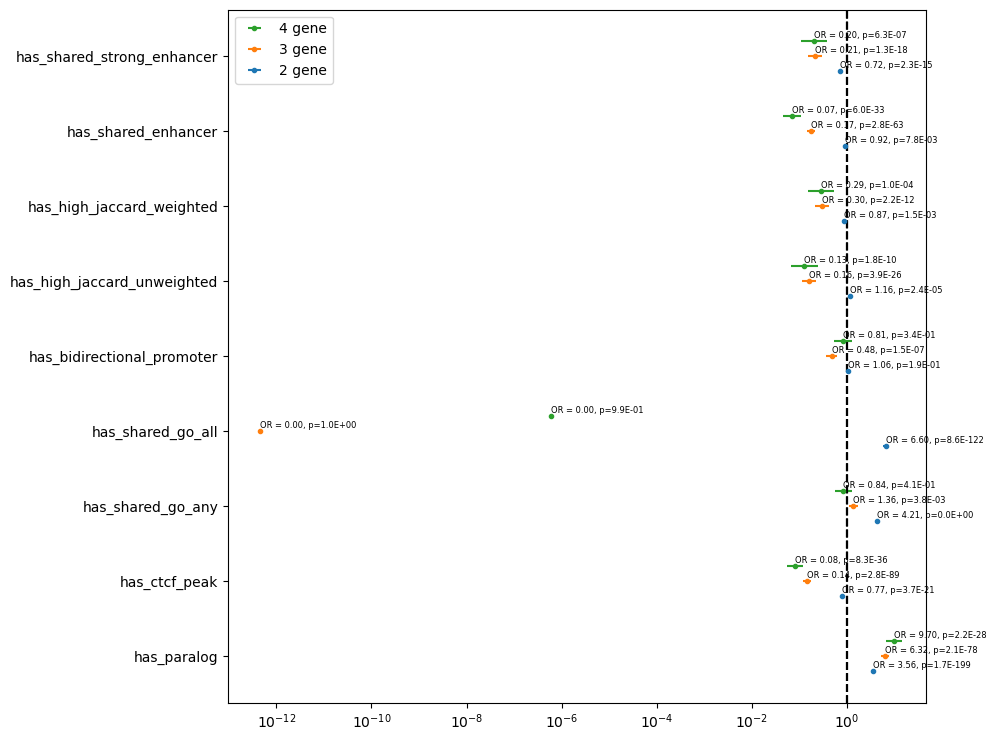

In [121]:
make_log_odds_plot_multiple([get_odds_df(multigene_resamp_joined_df[i], column_list=bool_column_list, filter_list=bool_filter_list) for i in [2,3,4]], 
                             labels=['2 gene', '3 gene', '4 gene'])

has_paralog
Optimization terminated successfully.
         Current function value: 0.175317
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:               119304
Model:                          Logit   Df Residuals:                   119301
Method:                           MLE   Df Model:                            2
Date:                Mon, 19 Aug 2024   Pseudo R-squ.:                  0.2075
Time:                        11:11:09   Log-Likelihood:                -20916.
converged:                       True   LL-Null:                       -26393.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           3.1249      0.084     37.296      0.000       2.961       3.289
N_genes       

<AxesSubplot: >

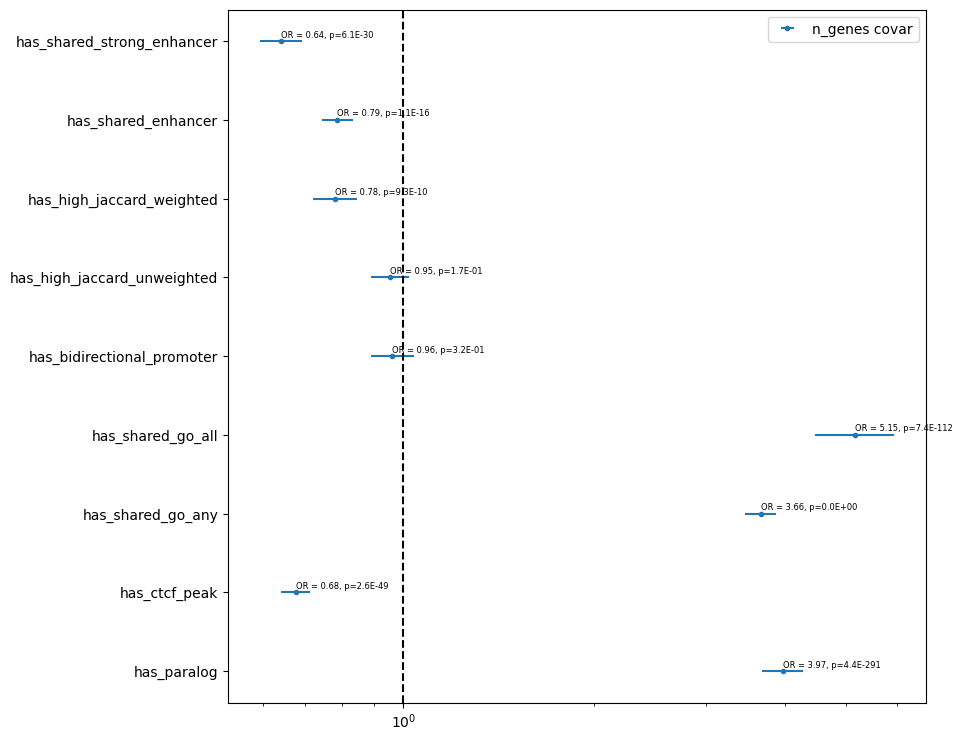

In [122]:
# distance resampled, with n genes as covariate
make_log_odds_plot_multiple([get_odds_df(pd.concat([multigene_resamp_joined_df[i] for i in [2,3,4]]), column_list=bool_column_list, filter_list=bool_filter_list, correct_on=True, correct_on_column='N_genes')], 
                             labels=['n_genes covar'])

has_paralog
Optimization terminated successfully.
         Current function value: 0.218238
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:               120725
Model:                          Logit   Df Residuals:                   120723
Method:                           MLE   Df Model:                            1
Date:                Mon, 19 Aug 2024   Pseudo R-squ.:                 0.01089
Time:                        11:11:19   Log-Likelihood:                -26347.
converged:                       True   LL-Null:                       -26637.
Covariance Type:            nonrobust   LLR p-value:                3.287e-128
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -2.9026      0.014   -213.478      0.000      -2.929      -2.876
has_paralog   

<AxesSubplot: >

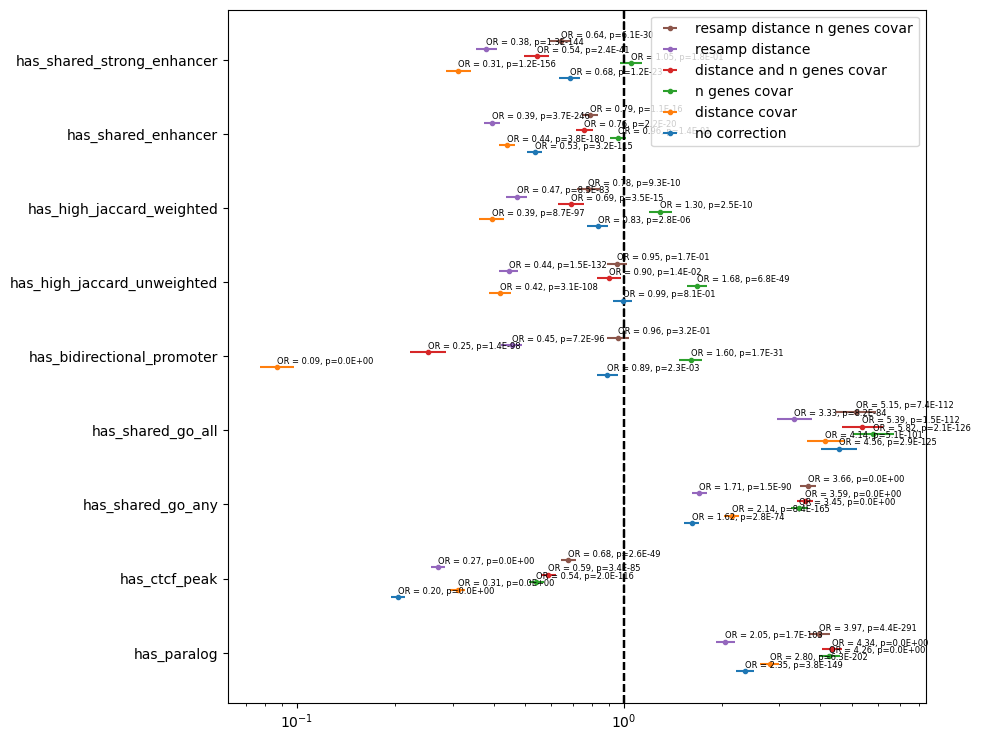

In [123]:
multigene_joined_df = pd.concat([combined_clusters, combined_multigene_nulls], keys=['cluster', 'null'], names=['type', 'idx'])
multigene_joined_df['log_size'] = np.log10(multigene_joined_df['cluster_tss_size'])
multigene_joined_df = multigene_joined_df[~(multigene_joined_df['has_cross_map'])]
multigene_joined_df = multigene_joined_df[multigene_joined_df['tissue'].isin(enhancer_tissue_ids)]

make_log_odds_plot_multiple([get_odds_df(multigene_joined_df, column_list=bool_column_list, filter_list=bool_filter_list, correct_on=False),
                             get_odds_df(multigene_joined_df, column_list=bool_column_list, filter_list=bool_filter_list, correct_on=True, correct_on_column='log_size'),
                             get_odds_df(multigene_joined_df, column_list=bool_column_list, filter_list=bool_filter_list, correct_on=True, correct_on_column='N_genes'),
                             get_odds_df(multigene_joined_df, column_list=bool_column_list, filter_list=bool_filter_list, correct_on=True, correct_on_column=['N_genes', 'log_size']),
                             get_odds_df(pd.concat([multigene_resamp_joined_df[i] for i in [2,3,4]]), column_list=bool_column_list, filter_list=bool_filter_list), 
                             get_odds_df(pd.concat([multigene_resamp_joined_df[i] for i in [2,3,4]]), column_list=bool_column_list, filter_list=bool_filter_list, correct_on=True, correct_on_column='N_genes')], 
                             labels=['no correction', 'distance covar', 'n genes covar', 'distance and n genes covar','resamp distance', 'resamp distance n genes covar'], offset=.1)

# cutoffs for boolean labels
I don't understand how 'mean_jaccard_weighted' can have a high coeefcient in a logisitc regression, but then the boolean version 'has_high_jaccard_weighted' doesn't. Maybe this is due to the threshold that determines yes/no for the boolean version?

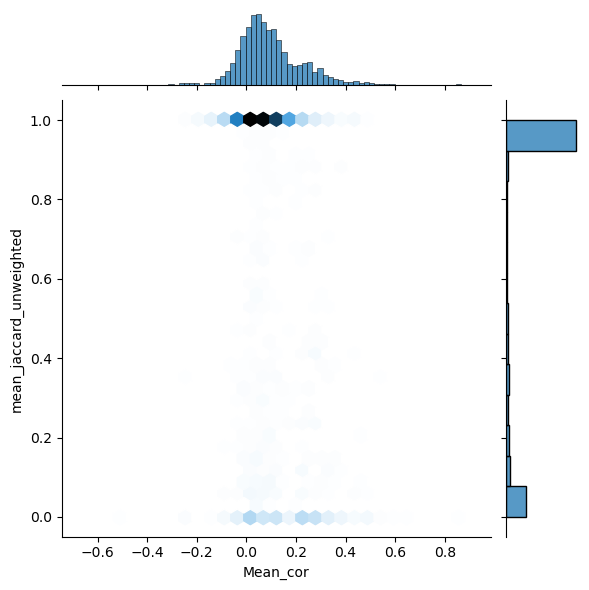

In [201]:
# start with a different quesiton - in linear regression does jaccard predict correlation? do this for the set of all pairs
multigene_joined_pairs = multigene_joined_df[multigene_joined_df['N_genes'] == 2]
multigene_joined_abc_pairs = multigene_joined_pairs[multigene_joined_pairs['num_enhancers']>0]
sns.jointplot(multigene_joined_abc_pairs[multigene_joined_abc_pairs['log_size']<np.log10(500)], x='Mean_cor', y='mean_jaccard_unweighted', kind='hex')

In [151]:
for i in range(100):
    cutoff = i/100
    multigene_joined_abc_pairs[f'test_jaccard_{cutoff}'] = multigene_joined_abc_pairs['max_jaccard_unweighted'] > cutoff

/local/scratch/klawren/slrmtmp.44132591/ipykernel_21560/4135855172.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  multigene_joined_abc_pairs[f'test_jaccard_{cutoff}'] = multigene_joined_abc_pairs['max_jaccard_unweighted'] > cutoff
/local/scratch/klawren/slrmtmp.44132591/ipykernel_21560/4135855172.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  multigene_joined_abc_pairs[f'test_jaccard_{cutoff}'] = multigene_joined_abc_pairs['max_jaccard_unweighted'] > cutoff
/local/scratch/klawren/slrmtmp.44132591/

In [152]:
jaccard_threshold_odds = get_odds_df(multigene_joined_abc_pairs, column_list = [f'test_jaccard_{cutoff/100}' for cutoff in range(100)])

test_jaccard_0.0
Optimization terminated successfully.
         Current function value: 0.379631
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                41239
Model:                          Logit   Df Residuals:                    41237
Method:                           MLE   Df Model:                            1
Date:                Mon, 19 Aug 2024   Pseudo R-squ.:               0.0007745
Time:                        11:25:48   Log-Likelihood:                -15656.
converged:                       True   LL-Null:                       -15668.
Covariance Type:            nonrobust   LLR p-value:                 8.371e-07
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -2.0144      0.023    -88.283      0.000      -2.059      -

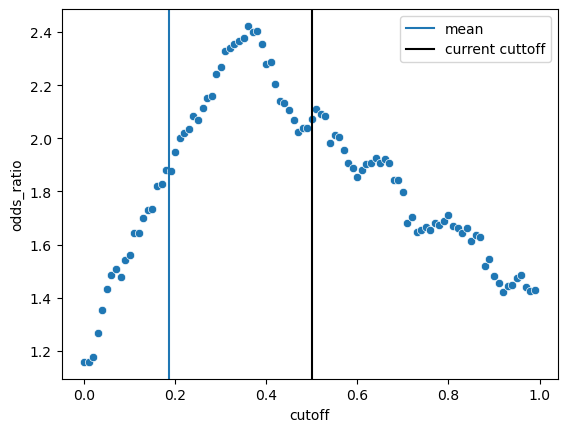

In [155]:
jaccard_threshold_odds['cutoff'] = [i/100 for i in range(100)]
ax = sns.scatterplot(x='cutoff', y='odds_ratio', data=jaccard_threshold_odds)
ax.axvline(x=np.mean(multigene_joined_abc_pairs['max_jaccard_unweighted']), label='mean')
ax.axvline(x=0.5, label='current cuttoff', color='k')
ax.legend()

In [196]:
x = multigene_joined_abc_pairs[['max_jaccard_unweighted', 'log_size']].astype(float)
y = multigene_joined_abc_pairs.reset_index()['type'].values == 'cluster'
x_with_constant = sm.add_constant(x) # Add intercept term
logit_model = sm.Logit(y, x_with_constant)

result = logit_model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.371008
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                41239
Model:                          Logit   Df Residuals:                    41236
Method:                           MLE   Df Model:                            2
Date:                Mon, 19 Aug 2024   Pseudo R-squ.:                 0.02347
Time:                        11:38:54   Log-Likelihood:                -15300.
converged:                       True   LL-Null:                       -15668.
Covariance Type:            nonrobust   LLR p-value:                1.959e-160
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -0.4924      0.086     -5.707      0.000      -0.662      -0.323
max_jaccard_unweighted     0.2565      0.055      4.684      0.000       0.149       0.364
log_size                  -0.3327      0.017    -19.079      0.000      -0.367      -0.299
==========================================================================================
"""

In [221]:
test_df = multigene_joined_df[multigene_joined_df['N_genes'] == 3]

x = test_df[['mean_jaccard_unweighted']].astype(float)
y = test_df.reset_index()['type'].values == 'cluster'
x_with_constant = sm.add_constant(x) # Add intercept term
logit_model = sm.Logit(y, x_with_constant)

result = logit_model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.062736
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                38321
Model:                          Logit   Df Residuals:                    38319
Method:                           MLE   Df Model:                            1
Date:                Mon, 19 Aug 2024   Pseudo R-squ.:                0.001357
Time:                        11:54:09   Log-Likelihood:                -2404.1
converged:                       True   LL-Null:                       -2407.4
Covariance Type:            nonrobust   LLR p-value:                   0.01057
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -4.3602      0.059    -73.688      0.000      -4.476      -4.244
mean_jaccard_unweighted    -0.7685      0.312     -2.465      0.014      -1.380      -0.157
===========================================================================================
"""

<AxesSubplot: xlabel='num_shared_enhancers', ylabel='Density'>

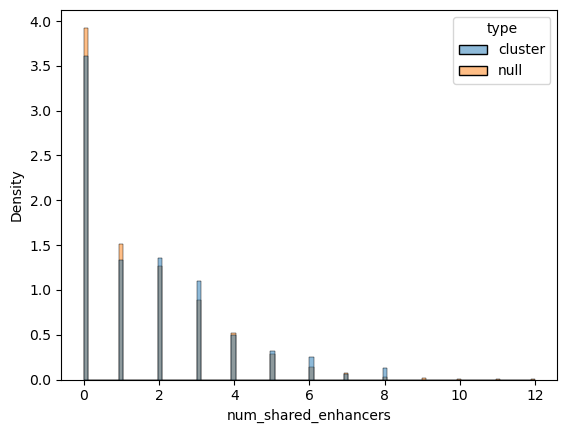

In [228]:
test_df = multigene_joined_df[(multigene_joined_df['N_genes'] == 2)&(multigene_joined_df['num_enhancers']>0)]
sns.histplot(test_df, x='num_shared_enhancers', hue='type', common_norm=False, stat='density')

In [246]:
def get_cluster_tss_size(row, gid_gencode):
    transcript_ids = row['Transcripts'].split(',')
    cluster_gencode = gid_gencode.loc[transcript_ids]
    return  cluster_gencode['tss_start'].max() - cluster_gencode['tss_start'].min()

def get_num_overlapping(row, gid_gencode):
    transcript_ids = row['Transcripts'].split(',')
    cluster_gencode = gid_gencode.loc[transcript_ids]
    return  sum((cluster_gencode['tss_start'] - cluster_gencode['tss_start'].shift(1)) < 1000)

In [255]:
transcript_ids = row['Transcripts'].split(',')

cluster_gencode = gid_gencode.loc[transcript_ids]
sum((cluster_gencode['tss_start'] - cluster_gencode['tss_start'].shift(1)) < 1000)

0

In [237]:
gid_gencode, full_gencode = load_gencode()
gene_enhancer_df = load_abc(full_gencode, my_tissue_id, 'data/references/functional_annotations/ABC_predictions/AllPredictions.AvgHiC.ABC0.015.minus150.ForABCPaperV3.txt.gz',
         'data/references/functional_annotations/ABC_predictions/ABC_matched_gtex.csv')

<AxesSubplot: xlabel='max_jaccard_weighted', ylabel='Density'>

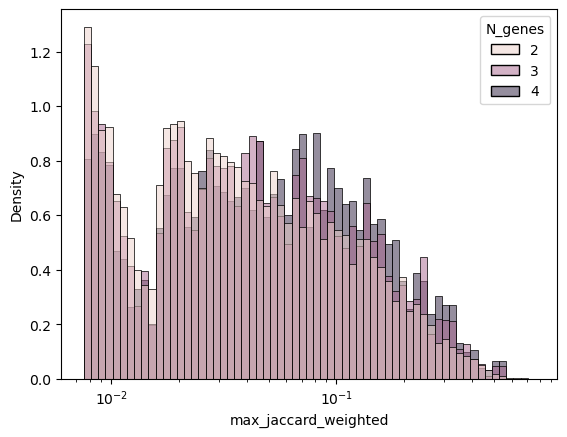

In [215]:
sns.histplot(multigene_joined_df[multigene_joined_df['N_genes']<5], x='max_jaccard_weighted', hue='N_genes', common_norm=False, stat='density', log_scale=True)

In [132]:
-1.7834 + 0.8922*np.mean(multigene_joined_abc_pairs['max_jaccard_unweighted'])

-1.6165305408675157

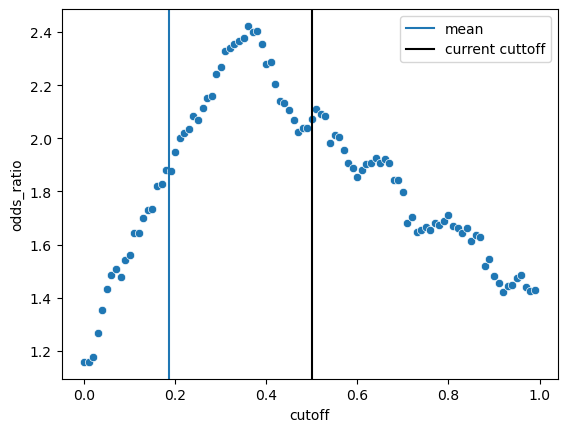

### final plot
N_genes as covar

In [ ]:
# postivie negative split for n gene covar, 